In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import numpy as np
from scipy.signal import argrelmax

import math
from itertools import takewhile

In [2]:
def format_exp (number, decimals=2):
    def exp_(f):
        return int(math.floor(math.log10(abs(f)))) if f != 0 else 0
    
    exponent = exp_(number)
    mantissa = number / 10**exponent
    
    return "%%.%if" % decimals % mantissa + "$\\times 10^{%s}$" % exponent

In [3]:
def read_file(folder_name = "./", file_name="B4_nt_B4_t%i.csv", num_threads=4, column_names = ["Energy", "Track_length"]):
    file_name = folder_name + file_name
    
    data = pd.read_csv (file_name % 0, comment="#", header=None, names=column_names)
    for i in range(1, num_threads):
        data = data.append(pd.read_csv (file_name % i, comment="#", header=None, names=column_names))
    
    return data

In [4]:
def read_with_angle (dir_name):
    data_with_angle = read_file(dir_name, column_names=["Energy", "Track_length", "p_X", "p_Y", "p_Z"])
    data_with_angle["angle"] = np.arccos(np.dot(data_with_angle[["p_X", "p_Y", "p_Z"]], [0,0,1]))
    return data_with_angle

In [47]:
def SimpleHistogram(X, name=None, plot_peaks=False, alpha=None, label=None, do_texts=True, bin_num=200):
    vals, bins, _ = plt.hist(X, bin_num, alpha=alpha, label=label);
    
    #ignore 0 and photopeak
    ylim  = vals[1:-1].max() * 1.1
    x_max = X.max()
    
    plt.ylim(0,ylim)
    plt.xlabel("E absorbed [MeV]")
    plt.ylabel("# of events")
    
    if do_texts:
        if bins[0] == 0:
            plt.text(0     + 0.005, ylim * 0.9, "<- %s" % format_exp(vals[0]),  horizontalalignment='left',  fontsize=8)
        
        if vals[-1] > ylim:
            plt.text(x_max - 0.005, ylim * 0.9, "%s ->" % format_exp(vals[-1]), horizontalalignment='right', fontsize=8)
    
    if plot_peaks:
        plot_peaks(bins[:-1], vals, ylim)
    
    if name:
        plt.savefig(name + ".svg")

In [6]:
def plot_peaks(x, y, ylim, diff=100, order=50):
    
    inds = argrelmax(y, order=order)[0]
    
    for ind in inds:
        plt.text(x[ind], min(y[ind], ylim)*0.9, "E = %.2f ->" % x[ind], horizontalalignment="right")

In [7]:
def plot_L_vs_E(data, name=None):
    plt.hist2d(data["Track_length"], data["Energy"], 50, norm=LogNorm());
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_facecolor("lightgray")
    colbar = plt.colorbar();
    colbar.set_label("# of events")
    
    plt.xlabel("Track length [m]")
    plt.ylabel("E absorbed [MeV]")
    
    if name:
        plt.savefig(name + ".svg")

In [48]:
data = read_file(column_names=["Energy", "Track_length", "p_X", "p_Y", "p_Z"])
data

,Energy,Track_length,p_X,p_Y,p_Z
0,1.000000,0.914596,0.000000,0.000000,1.000000
1,0.818028,1.045090,0.409069,-0.005816,-0.912485
2,0.694412,0.916748,0.901940,0.399254,-0.164624
3,0.556754,0.490054,0.627641,0.690259,0.360012
4,0.038119,0.008548,-0.195388,0.044323,0.979724
...,...,...,...,...,...
25419,1.000000,1.111440,0.000000,0.000000,1.000000
25420,0.353213,0.304353,-0.220131,-0.655663,0.722252
25421,0.245891,0.201651,-0.443040,0.383308,0.810426
25422,1.000000,1.007460,0.000000,0.000000,1.000000


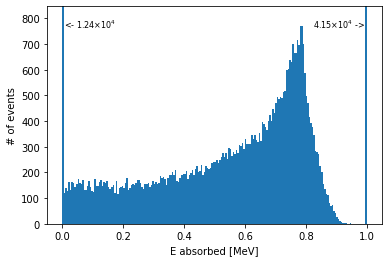

In [10]:
SimpleHistogram(data["Energy"])

(0, 1500)

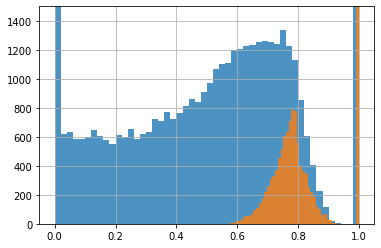

In [133]:
asd = data.groupby(pd.cut(data["Track_length"], [-np.inf, 0.8, np.inf]))
asd["Energy"].hist(stacked=True, alpha=0.8, bins=50)
plt.ylim(0, 1500)

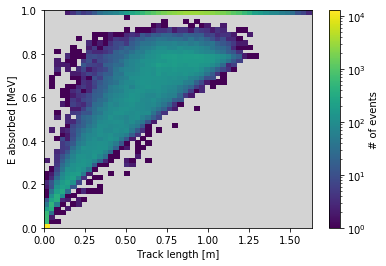

In [135]:
plot_L_vs_E(data)

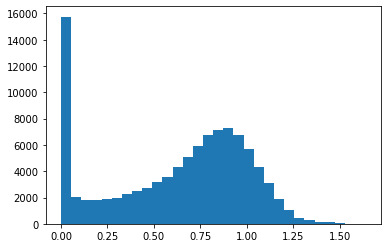

In [136]:
plt.hist(data["Track_length"], bins=30);

In [137]:
from scipy.stats import binned_statistic

avg, edges, _ = binned_statistic(data["Energy"], data["Track_length"], 'mean', bins=50)
x_ = edges[:-1]

/home/balazzs/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Average track length')

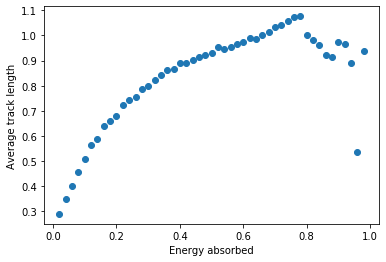

In [138]:
plt.plot(x_, avg/x_, "o")
plt.xlabel("Energy absorbed")
plt.ylabel("Average track length")

# Different physics

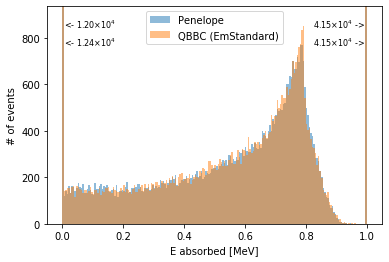

In [234]:
data_penelope = read_file("1MeV_cylinder_penelope/")
data_QBBC     = read_file("1MeV_cylinder_QBBC/")
SimpleHistogram(data_penelope["Energy"], alpha=0.5, label="Penelope")
SimpleHistogram(data_QBBC["Energy"]    , alpha=0.5, label="QBBC (EmStandard)")

plt.legend()

plt.savefig("physics_1MeV.svg")

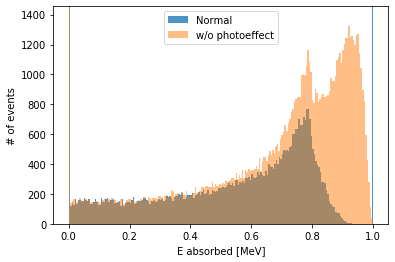

In [275]:
data_no_photo = read_file("1MeV_nophotoeffect_penelope/")
SimpleHistogram(data_penelope["Energy"], do_texts=False, alpha=0.8, label="Normal")
SimpleHistogram(data_no_photo["Energy"], do_texts=False, alpha=0.5, label="w/o photoeffect")
plt.legend();

plt.savefig("photoeffect.svg")

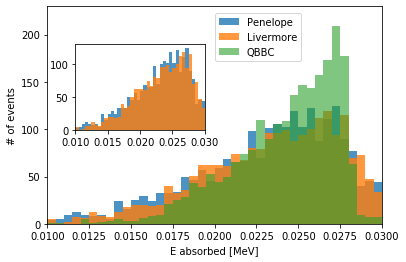

In [272]:
data_penelope_100kev  = read_file("100keV_penelope/")
data_QBBC_100kev      = read_file("100keV_QBBC/")
data_livermore_100kev = read_file("100keV_livermore/")

SimpleHistogram(data_penelope_100kev["Energy"] , do_texts=False, alpha=0.8, label="Penelope")
SimpleHistogram(data_livermore_100kev["Energy"], do_texts=False, alpha=0.8, label="Livermore")
SimpleHistogram(data_QBBC_100kev["Energy"]     , do_texts=False, alpha=0.6, label="QBBC")

plt.xlim(0.01, 0.03)
plt.legend(loc=(.5, .75))


left, bottom, width, height = [0.19, 0.45, 0.3, 0.3]
ax2 = plt.gcf().add_axes([left, bottom, width, height])
SimpleHistogram(data_penelope_100kev["Energy"] , do_texts=False, alpha=0.8, label="Penelope")
SimpleHistogram(data_livermore_100kev["Energy"], do_texts=False, alpha=0.8, label="Livermore")
plt.xlim(0.01, 0.03)
plt.ylabel("");
plt.xlabel("");

plt.savefig("physics_100keV.svg")

# Exit angle

## Absorbed energy angle dependence

In [67]:
def make_angle_vs_energy_plot (data):
    sub_data = data[np.logical_and(data["Energy"] != data["Energy"].max(), data["Energy"] != 0.0)]
    
    plt.hist2d(sub_data["angle"], sub_data["Energy"], bins=30, norm=LogNorm());
    cbar = plt.colorbar()
    
    plt.xlabel("Exit angle [rad]")
    plt.ylabel("Absorbed energy [MeV]")
    cbar.set_label("# of events")

In [98]:
data_10MeV_angle  = read_with_angle("exit_angle/10MeV/")
data_1MeV_angle   = read_with_angle("exit_angle/1MeV/")
data_511keV_angle = read_with_angle("exit_angle/511keV/")
data_250keV_angle = read_with_angle("exit_angle/250keV/")
data_100keV_angle = read_with_angle("exit_angle/100keV/")

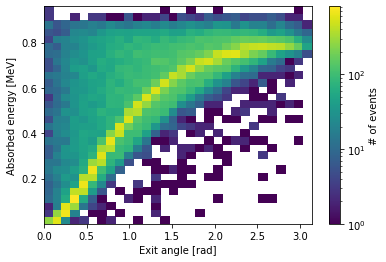

In [99]:
make_angle_vs_energy_plot(data_1MeV_angle)

## Exit direction distribution

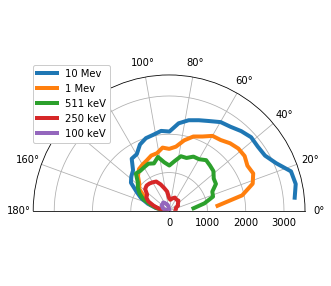

In [168]:
#exit direction distribution
plt.figure(figsize=(5,5))

vals, bins = np.histogram(data_10MeV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="10 Mev")
vals, bins = np.histogram(data_1MeV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="1 Mev")
vals, bins = np.histogram(data_511keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="511 keV")
vals, bins = np.histogram(data_250keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="250 keV")
vals, bins = np.histogram(data_100keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="100 keV")

plt.gca().set_thetamax(180)
plt.yticks([0, 1000, 2000, 3000])
plt.legend(loc= (0.0, 0.5), framealpha=1);

# World changed to air from vacuum

# Particla gun -> source

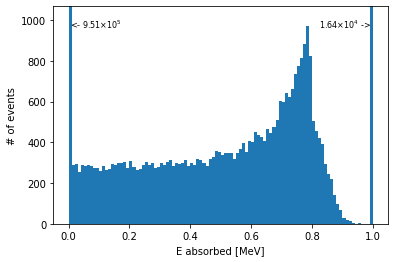

In [254]:
data_source = read_with_angle("distance/5/")
SimpleHistogram(data_source["Energy"], bin_num=100)

# Distance

In [268]:
def read_distance_vs_hits():
    dists = list(range(0, 20)) + list(range(20, 100, 5))
    hits  = []

    for dist in dists:
        data = read_with_angle ("./distance/%i/" % dist)
        hits.append((data["Energy"] > data["Energy"].max() * 0.95).sum())
    return dists, hists

dists, hits = read_distance_vs_hits()

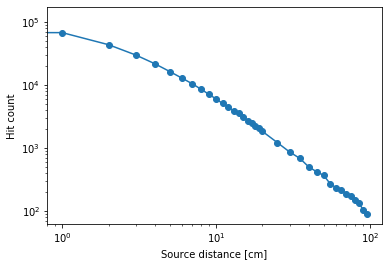

In [273]:
plt.plot(dists, hits, "o-")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Source distance [cm]")
plt.ylabel("Hit count")
plt.savefig("distance_vs_hits.svg")

# Uranium - gamma from table

In [19]:
data_U238_table = read_with_angle("data/uranium_table_simple_detector/")

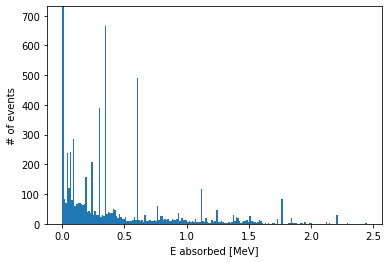

In [89]:
SimpleHistogram(data_U238_table["Energy"], do_texts=False)
plt.savefig("figures/U_238_table_simple_geom.svg")

In [65]:
primary_energies = np.loadtxt("data/uranium_table_simple_detector/primary_energies.txt")
table = np.loadtxt("build/U_238.txt")

Mean absolute difference: 0.027%


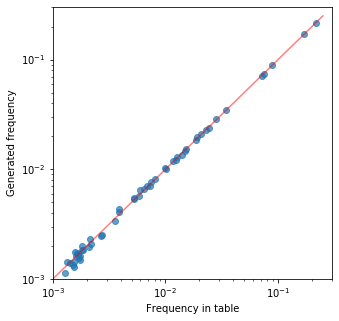

In [90]:
plt.figure(figsize=(5,5))

primary_numbers = np.unique(primary_energies, return_counts=True)[1]
primary_freq    = primary_numbers / sum(primary_numbers)

plt.scatter(table[:, 1], primary_freq, alpha=0.7)
plt.plot([0, 0.25], [0, 0.25], color="red", alpha=0.5)

plt.xlabel("Frequency in table")
plt.ylabel("Generated frequency")

plt.yscale("log")
plt.xscale("log")
plt.ylim(0.001, 0.3)
plt.xlim(0.001, 0.3)

avg_diff = sum(abs(table[:, 1] - primary_freq)) / len(table)
print ("Mean absolute difference: %.3f%%" % (avg_diff * 100))

plt.savefig("figures/U_238_table_simple_geom_frequency_check.svg")

# Better geometry

## U 238 table

In [45]:
data_geom_U238_table = read_with_angle("data/uranium_table_real_geom/")

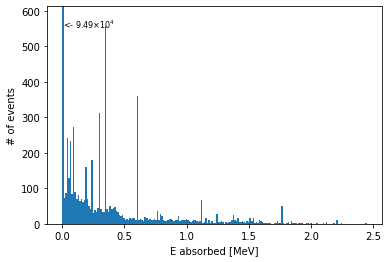

In [91]:
SimpleHistogram(data_geom_U238_table["Energy"])
plt.savefig("figures/U_238_table_real_geom.svg")

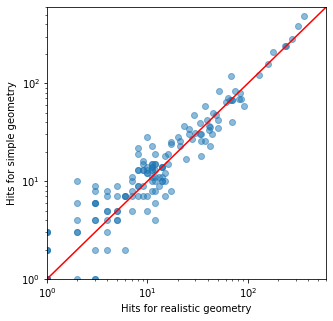

In [92]:
vals_1, bins_1 = np.histogram(data_geom_U238_table["Energy"], bins=200)
vals_2, bins_2 = np.histogram(data_U238_table["Energy"], bins=200)

plt.figure(figsize=(5,5))

plt.scatter(vals_1, vals_2, alpha=0.5)

plt.xlabel("Hits for realistic geometry")
plt.ylabel("Hits for simple geometry")

plt.xscale("log")
plt.yscale("log")
plt.xlim(1,600)
plt.ylim(1,600)

plt.plot([0,600], [0, 600], color="red");

plt.savefig("figures/U_238_table_simple_vs_real_geom.svg")

In [ ]:
## U 238 